In [26]:
def main(file):
    import torch 
    import time 
    
    f = open(file, 'w')

    print(torch.__version__)

    dtype=torch.half
    warm_up = 1000 
    n_iter = 1000

    f.write('n c h w ks\n')
    
    for n in (1, 32, 64): 
        for c in (1, 32, 64): 
            for h in (14, 28, 56, 128, 256): 
                w = h
                for ks in (2, 3, 5, 7): 
                    torch.cuda.empty_cache() 

                    f.write(f'{n} {c} {h} {w} {ks}\n')

                    ref_a = torch.randn(n, c, h, w, dtype=dtype, device='cuda').contiguous()
                    ref_a.requires_grad_() 
                    ref_pool = torch.nn.AvgPool2d(ks).cuda()
                    ref_out = ref_pool(ref_a)

                    grad = torch.ones_like(ref_out)
                    ref_out.backward(grad, retain_graph=True)

                    ########## warm up ##########
                    for _ in range(warm_up): 
                        ref_out = ref_pool(ref_a)
                        ref_out.backward(grad, retain_graph=True)

                    ########## contiguous forward ##########
                    torch.cuda.synchronize()
                    ts = time.time()

                    for _ in range(n_iter):
                        ref_out = ref_pool(ref_a)
                        torch.cuda.synchronize() 
                        
                    f.write('{:e}\n'.format((time.time() - ts) / n_iter))

                    ########## contiguous backward ##########
                    torch.cuda.synchronize()
                    ts = time.time()

                    for _ in range(n_iter):
                        ref_out.backward(grad, retain_graph=True)
                        torch.cuda.synchronize() 

                    f.write('{:e}\n'.format((time.time() - ts) / n_iter))
                    
                    f.flush()
    f.close()

## Before

In [27]:
main('before.txt')

1.6.0a0+301be85


## After

In [23]:
main('after.txt')

1.6.0a0+0a8fd79


## Compare

In [23]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

with open('before.txt', 'r') as f: 
    before = f.readlines() 
with open('after.txt', 'r') as f: 
    after = f.readlines() 

def parse(lines):
    d_fwd_time = {}
    d_back_time = {}
    
    for i in range(1, len(lines), 3): 
        line = lines[i] 
        
        tensor_size = line.rstrip()
        
        key = tensor_size
        
        def parse_time(linex):
            t = float(linex.rstrip())
            
            return t
            
        fwd_time = parse_time(lines[i+1])
        back_time = parse_time(lines[i+2])
    
        d_fwd_time[key] = fwd_time 
        d_back_time[key] = back_time
        
    return (d_fwd_time, d_back_time)   

d_fwd_before, d_back_before = parse(before)
d_fwd_after, d_back_after = parse(after)

def compare(d_before, d_after, s): 
    print('compare for', s)
    print()
    print('tensor size\tbefore\t\tafter\t\tregression')
    
    diffs = []
    for key in d_before: 
        t_before = d_before[key] 
        t_after = d_after[key] 
        
        diffs.append((t_after - t_before)/t_before * 100)
        
        if (t_after - t_before) / t_before > 0.05: 
            print(f"{key}", f"{t_before: e}", f"{t_after: e}", 
                  f"{(t_after - t_before) / t_before * 100.0 : .1f}%", sep='\t')
    
    print()
    print('(t_after - t_before) / t_before:')
    print('mean =', np.mean(diffs), '%')
    print('median =', np.median(diffs), '%')
    print('max =', np.max(diffs), '%')
    print('min =', np.min(diffs), '%')
    
    ax = sns.distplot(diffs)
    ax.set(xlabel='percentage regression', ylabel='PDF')
    plt.show()

compare for forward

tensor size	before		after		regression
1 1 14 14 2	 3.912520e-05	 5.678129e-05	 45.1%
1 1 14 14 3	 3.828764e-05	 5.722356e-05	 49.5%
1 1 14 14 5	 3.844523e-05	 5.811620e-05	 51.2%
1 1 14 14 7	 3.811097e-05	 5.710435e-05	 49.8%
1 1 28 28 2	 3.830910e-05	 5.847812e-05	 52.6%
1 1 28 28 3	 3.988004e-05	 5.724478e-05	 43.5%
1 1 28 28 5	 3.808188e-05	 5.768013e-05	 51.5%
1 1 28 28 7	 3.894496e-05	 5.804992e-05	 49.1%
1 1 56 56 2	 3.859282e-05	 5.799818e-05	 50.3%
1 1 56 56 3	 3.817582e-05	 5.756497e-05	 50.8%
1 1 56 56 5	 3.860760e-05	 5.798054e-05	 50.2%
1 1 56 56 7	 3.854465e-05	 5.855179e-05	 51.9%
1 1 128 128 2	 3.887963e-05	 5.698729e-05	 46.6%
1 1 128 128 3	 3.784823e-05	 5.686116e-05	 50.2%
1 1 128 128 5	 3.960991e-05	 5.684137e-05	 43.5%
1 1 128 128 7	 3.916359e-05	 5.739307e-05	 46.5%
1 1 256 256 2	 4.589725e-05	 5.770445e-05	 25.7%
1 32 14 14 3	 5.479360e-05	 5.765033e-05	 5.2%
1 64 14 14 5	 5.524564e-05	 5.966640e-05	 8.0%
1 64 28 28 5	 5.404615e-05	 5.726123e-

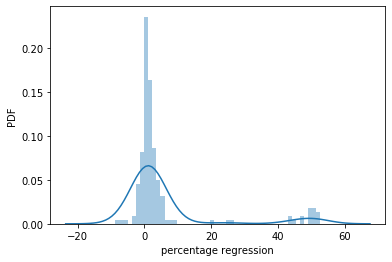

In [24]:
compare(d_fwd_before, d_fwd_after, 'forward')

compare for backward

tensor size	before		after		regression
1 1 14 14 2	 8.868170e-05	 1.168108e-04	 31.7%
1 1 14 14 3	 8.836126e-05	 1.155424e-04	 30.8%
1 1 14 14 5	 8.954978e-05	 1.156039e-04	 29.1%
1 1 14 14 7	 8.835721e-05	 1.169155e-04	 32.3%
1 1 28 28 2	 8.956075e-05	 1.181319e-04	 31.9%
1 1 28 28 3	 8.882093e-05	 1.146982e-04	 29.1%
1 1 28 28 5	 8.816600e-05	 1.166298e-04	 32.3%
1 1 28 28 7	 8.771634e-05	 1.190863e-04	 35.8%
1 1 56 56 2	 8.897233e-05	 1.150522e-04	 29.3%
1 1 56 56 3	 9.420919e-05	 1.164215e-04	 23.6%
1 1 56 56 5	 8.860826e-05	 1.153715e-04	 30.2%
1 1 56 56 7	 8.939481e-05	 1.252246e-04	 40.1%
1 1 128 128 2	 8.899236e-05	 1.112418e-04	 25.0%
1 1 128 128 3	 8.717895e-05	 1.136456e-04	 30.4%
1 1 128 128 5	 8.773994e-05	 1.120889e-04	 27.8%
1 1 128 128 7	 8.907938e-05	 1.123686e-04	 26.1%
1 1 256 256 5	 1.070549e-04	 1.136017e-04	 6.1%
1 32 14 14 2	 1.063941e-04	 1.137426e-04	 6.9%
1 32 14 14 3	 1.065946e-04	 1.180937e-04	 10.8%
1 32 14 14 5	 1.066260e-04	 1.140392e

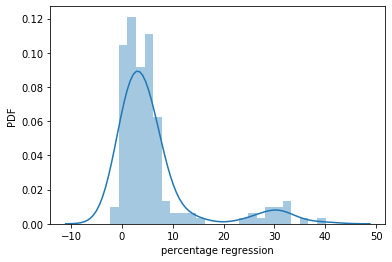

In [25]:
compare(d_back_before, d_back_after, 'backward')